<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/Practica7.4.%20Introducci%C3%B3n%20a%20GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

# Práctica 7.4. Redes generativas adversarias

Las Redes Generativas Adversarias (GANs) fueron desarrolladas por Goodfellow et al en 2014 como una alternativa a las VAEs para aprender espacios latentes de imágenes. Estas son capaces de generar imágenes sintéticas muy realistas forzando a que no sea capaz de determinar si la imagen generada es real o no. 

Intuitivamente podemos pensar en un falsificador intentando crear un Picasso y enseñando su falsificación a un experto en arte. Este experto hará una valoración de cada falsificación que prepare. Con el tiempo el falsificador irá mejorando su falsificación, imitando mejor y mejor el estilo de Picasso hasta que el experto sea incapaz de determinar que se trata de una falsificación.

Esto es exactamente lo que hacen las GANs: la red falsifica y otra red hará de experta.
 - La red generadora (falsificador) toma como entrada una vector aleatorio (un punto aleatorio del espacio latente) y la decodifica a una imagen sintética.
 - La red adversaria (experta) tomará como entrada una imagen (que podrá ser real o sintética) y determinará si ésta es real o fue creada por la red generadora.
 
El hecho de entrenadar la red generadora para engañar a la red adversaria hará que la red generadora vaya generando imágenes cada vez más realistas. Mientras tanto, la red adversaria se va adaptando a las mejoras de la red generadora. Cuando el entrenamiento converge, el generador será capa de decodificar cualquier vector en una imagen sintética y realista. A diferencia de la VAEs, el espacio latente generado no tendrá ningun estructura útil ni será continuo.

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/gan.png?raw=1' width=70% />

Hay que destacar que al entrenar una GAN el proceso de optimización no es fijo. En los ejemplos vistos hasta ahora, siempre se tenía una superfice de error fija, pero con las GANs, en cada iteración se modifica un poco la superficie la función de coste. Es un sistema dinámico en el que el sistema de optimización no buscará un mínimo, sino un equilibrio entre dos fuerzas. Por esta razón, las GANs son especialmente difíciles de entrenar. Conseguir que una GAN funcione requiere de una cuidadosa optimización de los parámetros y de la arquitectura de las redes.


## 1. Un boceto de la implementación

Vamos a ver cómo implementar una GAN en su forma más básica. Se han realizado avances significativos que requieren un estudio más profundo de detalles técnicos que quedan fuera de una introducción. Nuestra implementación será una GAN usando una red convolucional conocida como DCGAN (el generador y el discriminador son redes convolucionales). Como en el ejemplo anterior, usaremos la traspuesta de la convolución para pasar de un vector a una imagen en el generador.

Entrenaremos nuestra GAN con imágenes de CIFAR10. Recordemos que son 50.000 imágenes de 32x32 con 10 clases diferentes (5.000 muestras por clase). Para facilitar las cosas, usaremos la clase "rana" ("fog").

Esquemáticamente, nuestra GAN hará lo siguiente:

* La red `generadora` mapeará vectores de tamaño  `(latent_dim,)` a imágenes de tamaño `(32, 32, 3)`.
* La red `discriminadora` mapeará imágenes de tamaño (32, 32, 3) a una probabilidad entre 0 y 1.
* Uniremos las dos redes formando una cadena para formar la `gan`: `gan(x) = discriminador(generador(x))`. Esta composición nos dirá como de real es una imagen mapeada desde el espacio latente. 
* Entrenaremos el discriminador usando muestras reales y falsas generadas por el generador. Las muestras reales tendrán asociadas las etiqueta 1 y las generadas por el generador etiqueta 0. 
* Para entrenar el generador usaremos los gradientes usando como función de coste a la red `gan` anterior. Por tanto en cada iteración debemos actualizar los pesos del generador, de forma que hagamos que el discriminador vea las muestras generadas como más reales. 



## 2. Unos trucos para hacer una GAN efectiva

Como hemos mencionado, entrenar una GAN es complicado, por lo que hay una serie de trucos que hay que tener en mente. Como la mayoría de las cosas en Deep Learning, es más alquimia que ciencia. Estos trucos son heurísticos, no existe una teoría que los respalde. Si hay cierta idea intuitiva de por qué funcionan y está comprobado empíricamente, pero no necesariamente tiene que funcionar en todos los contextos.

Veremos algunos de los trucos que usaremos en nuestra implementación pero puedes encontrar más en la literatura:

* Usaremos la activación `tanh` como la última activación del generador en vez de una `sigmoid` (como suele ser usada para modelos similares).
* Muestrearemos puntos del espacio latente usando una *distribución normal* en vez de una distribución uniforme.
* La aleatoriedad nos ayuda a ganar robustez. Evitaremos que el entrenamiento se quede atascado. Introduciremos esta aletoriedad de dos formas:
  1. Usaremos dropout en el discriminador.
  2. Añadiremos ruido a las etiquetas del discriminador.


* Los gradientes dispersos pueden dificultar el entrenamiento. En Deep Learning la dispersión es normalmente deseable, pero no con las GANs. Hay dos elementos que puede producir dispersión:
  1. Las operaciones Max Pooling. Usaremos convoluciones por un paso mayor a 1 para llevar a cabo la reducción de dimensionalidad.
  2. Las activaciones ReLU. Usaremos la activación `LeakyReLU`, muy similar a la ReLU pero reduce la dispersión permitiendo valores negativos de las activaciones.
    
* Las imágenes generadas pueden presentar un efecto de cuadriculado. Para reducir este efecto usaremos un tamaño de kernel divisible por el paso usado en la convolución.

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/checkboard_effect.png?raw=1' width=60% />

## 3. El generador

Primero, desarrollaremos el modelo del *generador* para convertir un vector en una imagen:

In [2]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# Transformamos las entradas a lo que serán 128 mapas 
# de características 16x16:
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Añadimos una capa de convolución:
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Aplicamos la deconvolución
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Algunas convoluciones más
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Usamos tanh para la capa de salida con solo 3 mapas = RGB
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## 4. El  discriminador


El `discriminador` toma como entrada una imagen y la clasifica como real o no:

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# Truco!
x = layers.Dropout(0.4)(x)

# Capa de clasificación
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# Para estabilizar el entrenamiento usaremos una reducción 
# progresiva del learning rate y recortado de los 
# extremos de los gradientes.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

## 5. El modelo adversario

Por último definimos la cadena entre el discriminador y el generador. Este es el modelo que hará aprender al generador para mejorar su habilidad de engañar al discriminador. 


In [4]:
# Desactivamos el entrenamiento del discriminador
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 6. Entrenamiento de la DCGAN

Ahora empezamos con el entrenamiento. En resumen, el proceso de entrenamiento será el siguiente:

```
Por cada iteración (o época):
    * Muestrear vectores aleatorios del espacios latente (agregando un ruido aleatorio).
    * Generar imágenes con el generador usando estos vectores.
    * Mezclar la imágenes generadas con imágenes reales.
    * Entrenar el `discriminador` usando la mezcla anterior de imágenes con su correspondiente etiqueta.
    * Muestrear nuevos vectores aleatorios del espacio latente.
    * Entrenar la GAN usando esos vectores aleatorios pero con etiquetas diciendo que son reales. Esto hará que  se actualicen los pesos del generador, pero haciendo que las imágenes generadas parezcan más reales al discriminador.
```

Vamos a implementarlo:

In [5]:
import os
from keras.preprocessing import image

# Leemos CIFAR10 
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Seleccionamos las imágenes de ranas (clase 6)
x_train = x_train[y_train.flatten() == 6]

# Normalizamos los datos
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 50000
batch_size = 20

# Si no existe la carpeta tmp (solo la primera vez, después descomentar)
save_dir = './tmp'
os.mkdir(save_dir)

# Entrenamiento
start = 0
for step in range(iterations):
    # Muestreamos puntos aleatorios del espacio latente
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Generamos la imágenes con el generador
    generated_images = generator.predict(random_latent_vectors)

    # Mezclamos con imágenes reales
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Creamos la etiquetas
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    # Añadimos un ruido aleatorio a las etiquetas - Truco!
    labels += 0.05 * np.random.random(labels.shape)

    # Entrenamos el discriminador
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # Muestreamos puntos del espacio latente
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Las asociamos con muestras reales (no lo son!)
    misleading_targets = np.zeros((batch_size, 1))

    # Entrenamos el generador usando el modelo gan
    # que tiene los pesos del discriminador congelados
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Vamos guardando algunas muestras del entrenamiento
    # y guardamos el modelo
    if step % 100 == 0:
        # Guardamos los pesos del modelo
        gan.save_weights('gan.h5')

        # Imprimimos las métricas
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Guardamos una imagen generada
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Guardamos una imagen real para comparar
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

170500096/170498071 [==============================] - 2s 0us/step
discriminator loss at step 0: 0.6887067556381226
adversarial loss at step 0: 0.6844008564949036
discriminator loss at step 100: 0.7080549001693726
adversarial loss at step 100: 0.80656898021698
discriminator loss at step 200: 0.7161696553230286
adversarial loss at step 200: 0.7582142949104309
discriminator loss at step 300: 0.7154545187950134
adversarial loss at step 300: 0.7398998141288757
discriminator loss at step 400: 0.689486563205719
adversarial loss at step 400: 0.7180038094520569
discriminator loss at step 500: 0.6915756464004517
adversarial loss at step 500: 0.7403610944747925
discriminator loss at step 600: 0.6964472532272339
adversarial loss at step 600: 0.7393795847892761
discriminator loss at step 700: 0.7079530954360962
adversarial loss at step 700: 0.7405356168746948
discriminator loss at step 800: 0.7043722867965698
adversarial loss at step 800: 0.7757794857025146
discriminator loss at step 900: 0.707569

Veamos algunas de las imágenes generadas por nuestra GAN (en realidad, por nuestro generador):

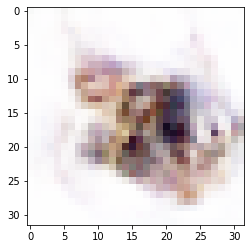

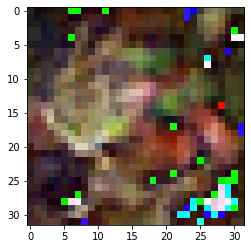

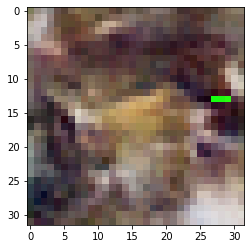

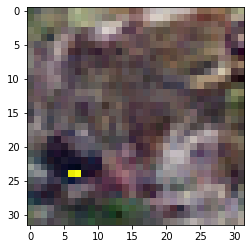

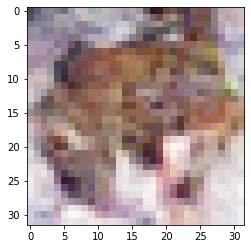

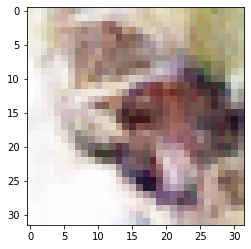

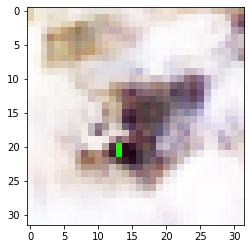

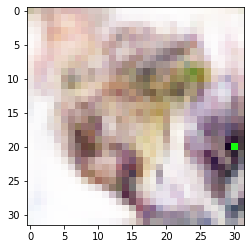

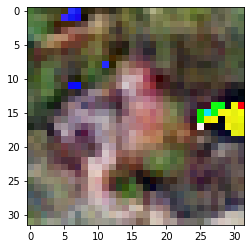

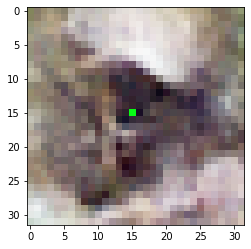

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# Muestreamos puntos aleatorios en el espacio latente
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Los decodificamos para imágenes falsas
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Recuerda que son imágenes generadas aleatoriamente, pero que se parecen a imágenes de la clase Froggy (rana), aunque con algunos fallos pixelados. 

Para hacernos una idea de la calidad de lo obtenido, vemoas algunas imágenes del conjunto de train (recuerda, de tamaño 32x32).

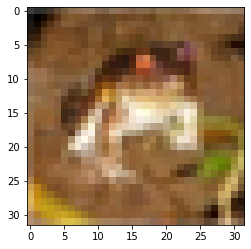

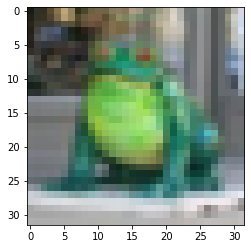

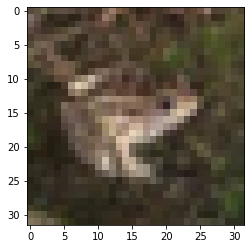

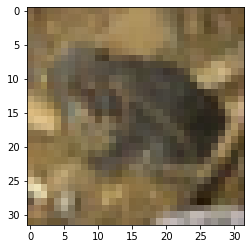

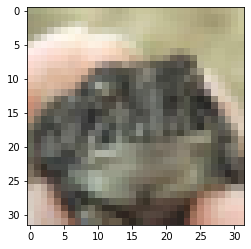

In [7]:
for i in range(5):
    img = image.array_to_img(x_train[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)

Si te interesa profundizar más, puedes encontrar implementaciones de diferentes GANs en el repositorio de github [Keras-GAN
](https://github.com/eriklindernoren/Keras-GAN) y en los ejemplos de la web oficial de [Keras](https://keras.io/examples/generative/).